# Comparison of MX3 to GPUs on Yolobench

This report compares the performance of the Memryx MX3 to several different NVIDIA GPUs. The models used are the 711 models from the Yolobench set https://github.com/Deeplite/deeplite-torch-zoo which fit onto four MX3 chips. The GPUs examined were the RTX A2000, RTX 4060, and the Jetson Orin AGX (with CUDA or TensorRT backends). In the case of the RTX A2000 and RTX 4060, the host system was an x86 workstation with an Intel Core i7-13700K CPU (16 cores) and with 64 GB of RAM.  The Jetson Orin AGX is a complete system.

In all cases the total time taken to process 2000 images was measured to determine frames per second (FPS). The processing time only includes the actual inference time, there is no pre- or post-processing.  The inputs batches are random tensors of shape (batch_size, 3, resolution, resolution) which are generated in a separate thread and put into a queue. The main thread pulls the batches from the queue and feeds them to the onnxruntime.  The first batch is treated as a "warmup" so it doesn't count toward the measurement. For the RTX A2000 and RTX 4060 the process was repeated with a batch size of 1, 2, 4, 6, and 8.  For the Jetson Orin AGX, only a batch size of 1 was used.

In [2]:
import pandas as pd
import numpy as np
from google_sheet_api import GoogleSheetAPI
import matplotlib.pyplot as plt

The MX3 benchmarking data comes from Tim. (Add more details here about the conditions of the test)

In [3]:
data_mx3 = pd.read_csv('yolobench_mx3_fps_latency.csv')
data_mx3 = data_mx3.rename(columns={"FPS": "FPS_MX3"})
data_mx3 = data_mx3.rename(columns={"InOutLatency": "latency_MX3"})
data_mx3 = data_mx3.set_index('Model')
data_mx3

,FPS_MX3,latency_MX3
Model,,
yolo3d1w25_160,1366.25,2.95
yolo3d1w25_192,950.78,3.48
yolo3d1w25_224,699.13,4.28
yolo3d1w25_256,535.85,4.91
yolo3d1w25_288,423.54,5.94
...,...,...
yolo8s_352,520.03,5.70
yolo8s_384,374.44,6.44
yolo8s_416,349.28,7.26


# Batch Size = 1 comparison

This section shows the results for batch size = 1. The data is pulled from a Google Sheet which contains the raw data and merged into one table (selecting only batch_size = 1) which looks like this:

In [4]:
# batch_size = 1 analysis
gs = GoogleSheetAPI('GPU-Auto-Bench1')
data_b1 = data_mx3.copy()
gpus = {'A2000': '528616448', '4060': '1360528374', 'AGX_CUDA': '13202610', 'AGX_TensorRT': '1697549124'}
for gpu_name, worksheet_id in gpus.items():
    gs.open_worksheet(worksheet_id)
    data_gpu = gs.get_dataframe('A1:F3556', includes_header=True)
    data_gpu_b1 = data_gpu[data_gpu['Batch Size'] == '1']
    data_gpu_b1 = data_gpu_b1.set_index('Model')
    data_gpu_b1 = data_gpu_b1.astype({'FPS': 'float'})
    column_name = 'FPS_' + gpu_name
    data_gpu_b1 = data_gpu_b1.rename(columns={'FPS': column_name})
    data_b1 = data_b1.join(data_gpu_b1[column_name])

print()

<bound method Spreadsheet.worksheets of <Spreadsheet 'GPU-Auto-Bench1' id:1IietP-8Y7HORErw4ijG6qe2rlmVyxBTKVelGJD80aDw>>



In [5]:
data_b1

,FPS_MX3,latency_MX3,FPS_A2000,FPS_4060,FPS_AGX_CUDA,FPS_AGX_TensorRT
Model,,,,,,
yolo3d1w25_160,1366.25,2.95,490.0,654.0,80.0,325.0
yolo3d1w25_192,950.78,3.48,465.0,599.0,77.0,315.0
yolo3d1w25_224,699.13,4.28,441.0,538.0,75.0,291.0
yolo3d1w25_256,535.85,4.91,427.0,510.0,71.0,282.0
yolo3d1w25_288,423.54,5.94,390.0,459.0,70.0,260.0
...,...,...,...,...,...,...
yolo8s_352,520.03,5.70,291.0,396.0,80.0,193.0
yolo8s_384,374.44,6.44,269.0,377.0,79.0,171.0
yolo8s_416,349.28,7.26,243.0,330.0,76.0,164.0


In [6]:
def geo_mean(xs):
    return np.exp(np.log(xs).mean())


def gen_summary_table(df):
    summary = pd.DataFrame({
        'Geo Mean': df.apply(geo_mean),
        'Mean': df.mean(),
        'Median': df.median(),
    })
    return  summary.T


def compare_to_mx3(data, field_name, png_name=None):
    # do linear fit with slope and offset
    x = np.stack([data[field_name], np.ones_like(data[field_name])], axis=1)
    fit, residuals, _, _ = np.linalg.lstsq(x, data_mx3.FPS_MX3, rcond=None)

    xmax = 1.05 * max(data.FPS_MX3)
    plt.plot(data[field_name], data.FPS_MX3,'.')
    plt.xlabel(field_name)
    plt.ylabel('FPS_MX3')
    plt.plot([0, xmax], [0, xmax], 'k--')
    plt.xlim([0, xmax])
    plt.ylim([0, xmax])
    plt.title('Yolobench FPS comparison')
    plt.plot([0, xmax], [fit[1], fit[1] + xmax * fit[0]], 'r-')
    ytext = 2800
    xtext = 50 + (ytext - fit[1]) / fit[0]
    plt.text(xtext, ytext, f'slope = {fit[0]:.2f}')

    plt.grid()
    if png_name:
        plt.savefig(png_name)
    plt.show()
    #mx3_gm = geo_mean(data.FPS_MX3)
    #gpu_gm = geo_mean(data[field_name])
    #print(f'geo mean, MX3: {mx3_gm:.1f}, {field_name}: {gpu_gm:.1f}')

Next we look at scatter plots which compare the FPS of the MX3 to each GPU.  Each dot in the plot represents one of the 711 models in the Yolobench set. Dots above the dotted line are where the MX3 had higher FPS, and dots below line the line the MX3 had lower FPS.  The red line is a least squares fit of a line to the data.  The slope of this line is one way to summarize the data.  The slope tells us approximately how much faster the MX3 compared to the GPU being considered. Other ways of summarizing the data will be shown in the table below.

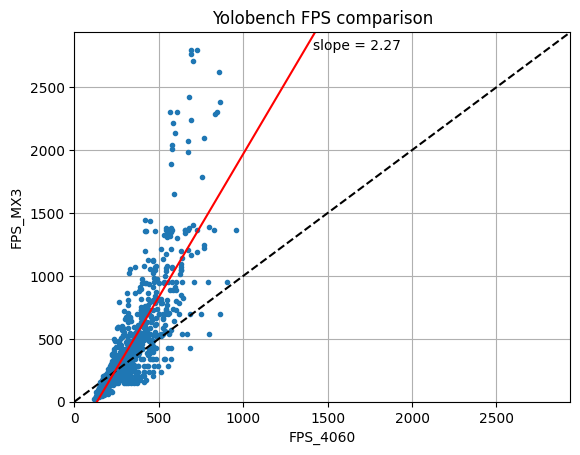

In [7]:
compare_to_mx3(data_b1, 'FPS_4060', png_name='yolobench_BS1_MX3_FPS_4060.png')

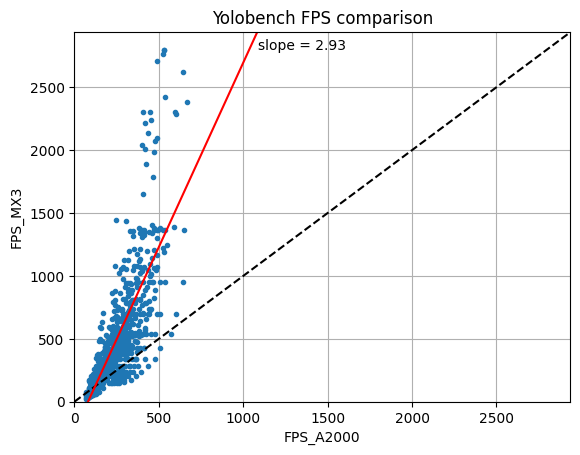

In [8]:
compare_to_mx3(data_b1, 'FPS_A2000', png_name='yolobench_BS1_MX3_FPS_A2000.png')

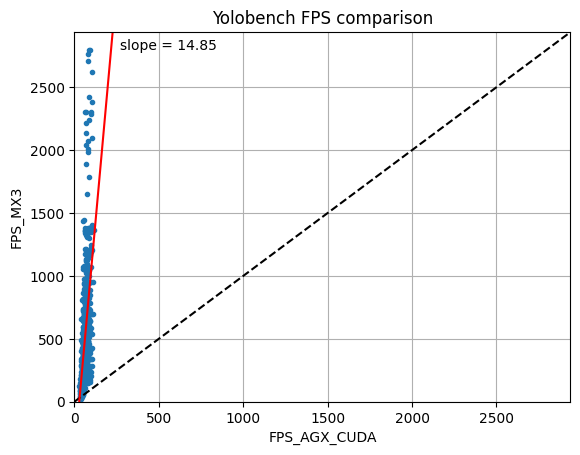

In [9]:
compare_to_mx3(data_b1, 'FPS_AGX_CUDA', png_name='yolobench_BS1_MX3_FPS_AGX_CUDA.png')

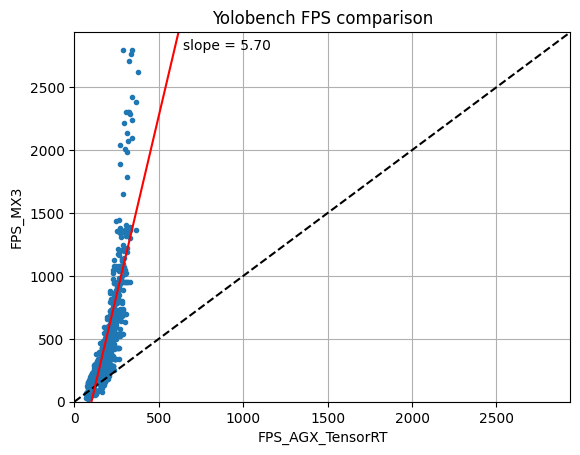

In [10]:
compare_to_mx3(data_b1, 'FPS_AGX_TensorRT', png_name='yolobench_BS1_MX3_FPS_AGX_TensorRT.png')

In [11]:
#data_b1.to_csv('yolobench_batch1B.csv')

We can also summarize the FPS values in a table:

In [12]:
selected_columns = ['FPS_MX3', 'FPS_A2000', 'FPS_AGX_CUDA', 'FPS_AGX_TensorRT']
table = gen_summary_table(data_b1[selected_columns])
pd.options.display.float_format = '{:.1f}'.format
table

,FPS_MX3,FPS_A2000,FPS_AGX_CUDA,FPS_AGX_TensorRT
Geo Mean,371.7,228.6,61.2,179.4
Mean,512.0,255.4,63.1,190.8
Median,375.2,238.0,61.0,188.0


# Similar Latency Comparison

Another way to compare the MX3 to the GPU is to select a GPU batch size which gives similar latency to the MX3. For the RTX A2000 and RTX 4060 we ran with batch sizes of 1, 2, 4, 6, and 8. After we have all the data we select the batch size which gives the best match in latency to the MX3.  After merging the data and doing the selection the table looks like this:

In [13]:

data_mx3 = pd.read_csv('yolobench_mx3_fps_latency.csv')
data_mx3 = data_mx3.rename(columns={"FPS": "FPS_MX3"})
data_mx3 = data_mx3.rename(columns={"InOutLatency": "latency_MX3"})
data_mx3 = data_mx3.set_index('Model')
data_mx3 = data_mx3.sort_values(by='latency_MX3')

gs = GoogleSheetAPI('GPU-Auto-Bench1')
gpus = {'A2000': '528616448', '4060': '1360528374'}
for gpu_name, worksheet_id in gpus.items():
    gs.open_worksheet(worksheet_id)
    data_gpu = gs.get_dataframe('A1:E3556', includes_header=True)
    data_gpu = data_gpu.set_index('Model')
    data_gpu = data_gpu.drop(columns='Resolution')
    data_gpu = data_gpu.astype({'Latency(ms)': 'float'})
    data_gpu = data_gpu.astype({'FPS': 'float'})
    data_gpu = data_gpu.rename(columns={'Batch Size': f'Batch Size {gpu_name}'})
    data_gpu = data_gpu.rename(columns={'FPS': f'FPS_{gpu_name}'})
    data_gpu = data_gpu.rename(columns={'Latency(ms)': f'latency_{gpu_name}'})
    data_gpu = data_gpu.sort_values(by=f'latency_{gpu_name}')
    # for each model, select the batch size with smallest value of |latency_MX3 - latency_GPU|
    data_mx3 = pd.merge_asof(data_mx3, data_gpu, by='Model', left_on='latency_MX3', right_on=f'latency_{gpu_name}', direction='nearest')

<bound method Spreadsheet.worksheets of <Spreadsheet 'GPU-Auto-Bench1' id:1IietP-8Y7HORErw4ijG6qe2rlmVyxBTKVelGJD80aDw>>


In [14]:
data_mx3 = data_mx3.sort_values(by='Model')
data_mx3

,Model,FPS_MX3,latency_MX3,Batch Size A2000,FPS_A2000,latency_A2000,Batch Size 4060,FPS_4060,latency_4060
37,yolo3d1w25_160,1366.2,3.0,2,877.0,3.4,2,1028.0,2.9
64,yolo3d1w25_192,950.8,3.5,2,797.0,3.8,2,937.0,3.2
100,yolo3d1w25_224,699.1,4.3,2,738.0,4.1,2,911.0,3.3
136,yolo3d1w25_256,535.9,4.9,2,638.0,4.7,4,1219.0,5.7
198,yolo3d1w25_288,423.5,5.9,2,575.0,5.2,4,997.0,7.0
...,...,...,...,...,...,...,...,...,...
187,yolo8s_352,520.0,5.7,1,291.0,3.4,2,521.0,5.8
230,yolo8s_384,374.4,6.4,2,334.0,9.0,2,496.0,6.0
268,yolo8s_416,349.3,7.3,1,243.0,4.1,2,423.0,7.1
307,yolo8s_448,287.4,8.0,1,221.0,4.5,2,365.0,8.2


Then we can make similar plots as shown above, but this time using the FPS values from the batch size which gives similar latency.

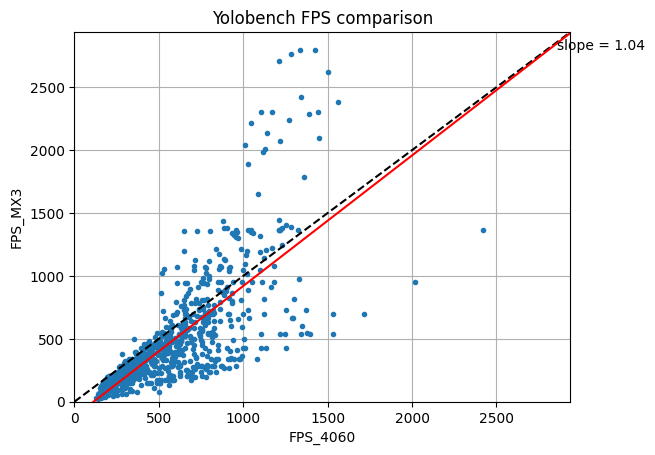

In [15]:
compare_to_mx3(data_mx3, 'FPS_4060', png_name='yolobench_SL_MX3_FPS_4060.png')

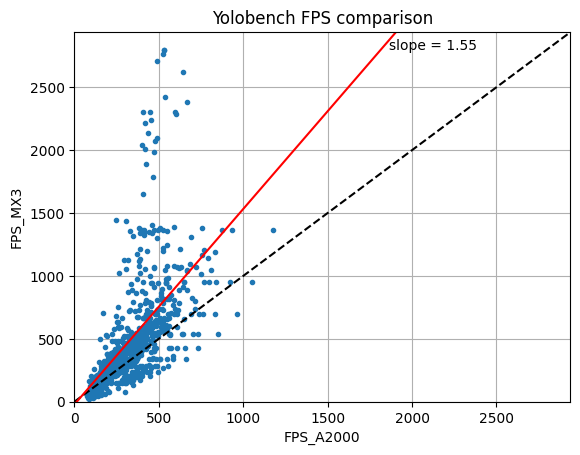

In [16]:
compare_to_mx3(data_mx3, 'FPS_A2000', png_name='yolobench_SL_MX3_FPS_A2000.png')

In [17]:
#data_mx3.to_csv('yolobench_similar_latency.csv')

In [20]:
#data_mx3.describe()

Summarize the FPS results in a table:

In [19]:
selected_columns = ['FPS_MX3', 'FPS_A2000', 'FPS_4060']
table = gen_summary_table(data_mx3[selected_columns])

pd.options.display.float_format = '{:.1f}'.format
table

,FPS_MX3,FPS_A2000,FPS_4060
Geo Mean,371.7,300.1,525.7
Mean,512.0,343.5,607.0
Median,375.2,328.0,568.0
